# Robustness Noise 
In order to understand the results better from the testing so far, in particular the plots, we want to analyse how noise influences our computations.
This serves the overall goal of improving our method with noisy data.
Following questions arise:

How can we bound the finite difference method?

How stable is the SVD to noise?

We only consider noise which is normally distributed? Does this influence our result?

What is the relation between the highest and the lowest singular value? Do they grow/shrink in a similar way when confronted with noise?

In [6]:
import numpy as np
from numpy.linalg import matrix_rank, svd
import pysindy as ps
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d

In [7]:
from error_bounds import *
from test_data import create_data_2d

## SVD Robustness Noise
There is a theorem and a corollary:

Theorem 2.18 (Mirsky). If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\sqrt{\sum_{k=1}^{r}|\sigma_k(A+E) - \sigma_k(A)|} \leq \lVert E \rVert_F$

Corollary:
If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\forall k \ |\sigma_k(A+E) - \sigma_k(A)| \leq \lVert E \rVert$

#### 1. What is the spectral and Frobenius norm of random noise matrices?

In [2]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -10,10
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
#matrix[:, 1] = alpha*matrix[:,2]
#matrix[:, 1] = 1e-12*matrix[:,1]
print(matrix)

[[ 1.6461398   2.69165195 -8.02719825]
 [-8.13487913  2.94959591 -9.77390706]
 [-5.31668427 -4.74762877 -8.74011969]
 [-6.11178543  7.31437159 -3.31163953]
 [-5.93359725  6.4871296  -3.11566772]
 [-3.16208431  8.88074541 -9.17994174]
 [-1.05015898  1.45626879  6.76007224]
 [-5.6827766  -3.86521655  5.72961269]
 [-4.56778068  6.90378593  5.06440867]
 [-2.14946749 -6.8758946   6.90386907]]


In [3]:
sv=svd(matrix, compute_uv=False)
print(matrix_rank(matrix),sv)
print(sv[0]/sv[-1])
print(np.linalg.norm(matrix))
print(np.linalg.norm(matrix,ord=2))

3 [25.28488555 15.69400654 13.07835634]
1.9333381724772036
32.50647140778908
25.284885551946104


Add noise

In [4]:
#np.random.seed(12)
target_noise=1e-3
var = target_noise * np.sqrt(np.mean(np.square(matrix)))
noise = np.random.normal(0, var, size=matrix.shape)
matrix_noise = matrix + noise
print(f"Added Gaussian noise with variance {var}")

Added Gaussian noise with variance 0.005934842551647597


In [5]:
print("Noise Matrix")
#print(noise)
print(f"Matrix rank: {matrix_rank(noise)}, SVD: {svd(noise, compute_uv=False)}")
print(f"Frobenius norm:\t {np.linalg.norm(noise)}")
print(f"Spectral norm:\t {np.linalg.norm(noise,ord=2)}")

Noise Matrix
Matrix rank: 3, SVD: [0.02332924 0.01846244 0.0116273 ]
Frobenius norm:	 0.03194228004793482
Spectral norm:	 0.02332923999248939


Print SVD and matrix rank with additional noise

In [6]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t \t matrix rank \t svd \t \t \t \t \t \t \t Frobenius \t \t \t Spectral")
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix + noise
    print(f" {target_noise}      \t \t {matrix_rank(matrix_noise)} \t \t {svd(matrix_noise, compute_uv=False)}     \t {np.linalg.norm(noise)}      \t {np.linalg.norm(noise,ord=2)}")

Noise level 	 	 matrix rank 	 svd 	 	 	 	 	 	 	 Frobenius 	 	 	 Spectral
 0      	 	 3 	 	 [25.28488555 15.69400654 13.07835634]     	 0.0      	 0.0
 1e-10      	 	 3 	 	 [25.28488555 15.69400654 13.07835634]     	 2.9686156307057834e-09      	 2.327793181296656e-09
 1e-09      	 	 3 	 	 [25.28488555 15.69400655 13.07835634]     	 3.02453138924868e-08      	 2.1892462250675672e-08
 1e-08      	 	 3 	 	 [25.28488555 15.69400656 13.0783563 ]     	 2.677878631708861e-07      	 1.8779053924717648e-07
 1e-07      	 	 3 	 	 [25.2848856  15.69400738 13.07835575]     	 3.521814138945382e-06      	 2.5880301034121684e-06
 1e-06      	 	 3 	 	 [25.2848799  15.69400051 13.07835693]     	 2.8619593204492694e-05      	 2.1296272815474944e-05
 1e-05      	 	 3 	 	 [25.28479573 15.69404971 13.07835723]     	 0.00028076089041267216      	 0.00021503580219267725
 0.0001      	 	 3 	 	 [25.28418512 15.69369526 13.07935619]     	 0.0032517695012660723      	 0.0023771790699705937
 0.001      	 	 3 	 	 [

Although the Frobenius Norm might not be that high in relation to the highest singular value. In relation to the smallest singular value it can be quite significant. Thus, the changes in the smallest singular value can be more disturbing for our purpose.

#### 2. What is the ratio between the smallest and biggest singular value?

The idea is if $A \in \mathbb{R}^{nxm}$ for $m<n$ has full rank $\frac{\sigma_1}{\sigma_m} < \infty$, but if it does not have full rank $\frac{\sigma_1}{\sigma_m} = \infty$

The bound that we use in the following is for $ \|B\|=max(\frac{1}{\sigma_n},\frac{\sigma_1}{\sigma_n^2}), \ \|B\|_F^2=\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2$
\begin{equation}
    | \frac{\sigma_1(A+E)}{\sigma_n(A+E)} - \frac{\sigma_1(A)}{\sigma_n(A)} | < \|B\|\|E\|
\end{equation}

In [5]:
# This calculates the above given bound
def calc_bound_ratio(sv_max,sv_min,noisematrix):
    #E=np.linalg.norm(noisematrix) #Spectral: order=2, Frobenius: default
    B=np.sqrt(1/sv_min+(sv_max/sv_min**2)**2)
    E=np.linalg.norm(noisematrix,ord=2) #Spectral: order=2, Frobenius: default
    #B=max(1/sv_min,sv_max/sv_min**2)
    return E*B

In [8]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
#matrix = np.random.random(size=(rows,cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
#matrix[:, 1] = matrix[:,2]
#matrix[:,0] = np.random.rand()*matrix[:,2]
#matrix[:, 2] *=1e6
#matrix[:, 0] *=1e6
print(matrix)

0.9318106730205307
[[-0.68628808 -1.21757948 -3.36750183]
 [-2.71086129  0.42195961  0.51257449]
 [-2.40002002 -1.27133346  0.48131238]
 [-3.66194459 -3.99697621 -2.54775694]
 [ 0.06740765 -3.78264368 -0.32395782]
 [ 0.64225417 -1.46979448 -2.98751684]
 [-2.31852662 -0.85031889 -2.54381063]
 [ 0.58058511 -0.80142418 -3.02386552]
 [-2.44460237  0.42450086 -3.35674124]
 [-2.27462053 -0.46936578 -0.69513449]]


In [9]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio big/smalles singular value: {sv[0]/sv[-1]}")
print(f"Bound: {calc_bound_ratio(sv_max,sv_min,np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 3
Singular values : [9.37670537 5.27040966 4.55829994]
Ratio big/smalles singular value: 2.0570619541172013
Bound: 0.0


In [10]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t \t \t  ratio \t bound")
ratios =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound=calc_bound_ratio(sv_max,sv_min,noise)
    ratios.append(np.abs(ratio-sv_max/sv_min))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t \t\t{ratio:3.3e}  \t {bound:3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	 	 	  ratio 	 bound
 0	 	 3 	 	 [9.37670537 5.27040966 4.55829994] 	 		2.057e+00  	 0.000e+00
 1e-10	 	 3 	 	 [9.37670537 5.27040966 4.55829994] 	 		2.057e+00  	 4.700e-10
 1e-09	 	 3 	 	 [9.37670537 5.27040966 4.55829994] 	 		2.057e+00  	 5.258e-09
 1e-08	 	 3 	 	 [9.37670534 5.27040965 4.55829994] 	 		2.057e+00  	 6.427e-08
 1e-07	 	 3 	 	 [9.37670553 5.27041    4.55829977] 	 		2.057e+00  	 5.411e-07
 1e-06	 	 3 	 	 [9.37670415 5.27040584 4.55829749] 	 		2.057e+00  	 5.319e-06
 1e-05	 	 3 	 	 [9.37672675 5.27045447 4.55832211] 	 		2.057e+00  	 8.473e-05
 0.0001	 	 3 	 	 [9.37671483 5.27071996 4.55781924] 	 		2.057e+00  	 5.976e-04
 0.001	 	 3 	 	 [9.37390196 5.27143812 4.55976929] 	 		2.056e+00  	 3.688e-03
 0.01	 	 3 	 	 [9.34744206 5.29764153 4.56614636] 	 		2.047e+00  	 4.750e-02
 0.1	 	 3 	 	 [9.53534471 4.9896515  4.89988398] 	 		1.946e+00  	 6.816e-01


Since for matrix with not full rank the bound is very high, I want to test the deviation for the same noise level

In [11]:
trials=10
noise_level=1e-10
differences=[]
bounds=[]
print(f"Noise level:  {noise_level}, Number trials: {trials}, True ratio: {sv_max/sv_min}")
print("Trial \t matrix rank \t sv \t \t \t \t \t \t \t  ratio \t \t bound \t \t \t difference")
for trial in range(trials):
    var = noise_level * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = calc_bound_ratio(sv_max,sv_min,noise)
    bounds.append(bound)
    differences.append(np.abs(ratio-sv_max/sv_min))
    print(f" {trial}\t \t {matrix_rank(matrix_noise)} \t {sv}   \t  {ratio:3.3e}   \t \t {bound:3.3e} \t \t {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level:  1e-10, Number trials: 10, True ratio: 2.0570619541172013
Trial 	 matrix rank 	 sv 	 	 	 	 	 	 	  ratio 	 	 bound 	 	 	 difference
 0	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 5.313e-10 	 	 1.868e-10
 1	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 5.630e-10 	 	 2.282e-10
 2	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 6.032e-10 	 	 2.631e-11
 3	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 6.234e-10 	 	 1.969e-12
 4	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 6.744e-10 	 	 1.133e-10
 5	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 5.330e-10 	 	 1.887e-10
 6	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 4.446e-10 	 	 8.139e-11
 7	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 5.229e-10 	 	 1.408e-10
 8	 	 3 	 [9.37670537 5.27040966 4.55829994]   	  2.057e+00   	 	 5.105e-10 	 	 1.024e-10
 9	 	 3 	 [9.37670537 5.27040966 4.55829994]  

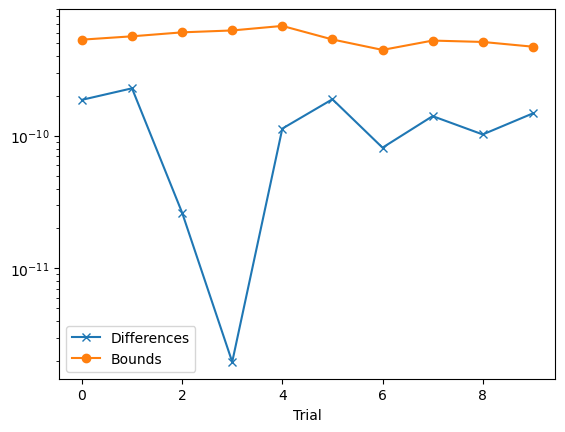

In [12]:
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.yscale('log')
plt.xlabel('Trial')
plt.legend()

Plot range of sv_max/sv_min: $$\max(0,\frac{\sigma_1(A)}{\sigma_n(A)}  - \|B\|\|E\|) <\frac{\sigma_1(A+E)}{\sigma_n(A+E)} < \frac{\sigma_1(A)}{\sigma_n(A)} | + \|B\|\|E\|$$

In [ ]:
#This returns two values
#lower_bound: omax/omin -BE
#upper_bound: BE + omax/min
def calc_range_ratio(sv_max,sv_min,noisematrix):
    #E=np.linalg.norm(noisematrix) #Spectral: order=2, Frobenius: default
    B=np.sqrt(1/sv_min+(sv_max/sv_min**2)**2)
    E=np.linalg.norm(noisematrix,ord=2) #Spectral: order=2, Frobenius: default
    lower_bound=max(0,sv_max/sv_min - B*E)
    upper_bound=B*E + sv_max/sv_min
    return lower_bound, upper_bound

In [14]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:, 1] *=1e-6
#matrix[:, 1] = matrix[:,2]
print(matrix)

0.2654416934517373
[[-3.57143349e-01  6.92252047e-07 -2.36061457e+00]
 [-3.30916276e+00 -1.47068907e-06 -3.76379394e-01]
 [-2.88248408e+00  3.98290297e-07 -2.87352378e+00]
 [-1.07209492e+00 -3.68128289e-06 -1.40300994e+00]
 [-4.51902930e+00  8.04812796e-07 -3.14458973e+00]
 [-2.44345655e+00  9.51824779e-07 -1.23567493e+00]
 [-2.99509564e+00 -4.88410466e-06 -3.80867910e+00]
 [-2.20159226e+00 -3.78032860e-06 -1.95724828e+00]
 [-2.12308853e+00 -4.05566514e-06 -1.47727282e+00]
 [ 4.75107851e-01 -3.40943160e-06 -4.39793449e+00]]


In [15]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio big/smalles singular value: {sv[0]/sv[-1]}")
print(f"Bound: {calc_bound_ratio(sv_max,sv_min,np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 3
Singular values : [1.05936109e+01 4.52445138e+00 7.23476511e-06]
Ratio big/smalles singular value: 1464264.6591803024
Bound: 0.0


In [16]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t \t \t \t ratio \t \t bound")
ratios =[]
ups,lows =[],[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound = calc_bound_ratio(sv_max,sv_min,noise)
    bounds.append(bound)
    low,up=calc_range_ratio(sv_max,sv_min,noise)
    ratios.append(ratio)
    lows.append(low)
    ups.append(up)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv}   \t  \t{ratio:3.3e}  \t {bound:3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	 	 	 	 ratio 	 	 bound
 0	 	 3 	 	 [1.05936109e+01 4.52445138e+00 7.23476511e-06]   	  	1.464e+06  	 0.000e+00
 1e-10	 	 3 	 	 [1.05936109e+01 4.52445138e+00 7.23471581e-06]   	  	1.464e+06  	 2.031e+02
 1e-09	 	 3 	 	 [1.05936109e+01 4.52445138e+00 7.23682042e-06]   	  	1.464e+06  	 1.817e+03
 1e-08	 	 3 	 	 [1.05936109e+01 4.52445137e+00 7.23131140e-06]   	  	1.465e+06  	 1.557e+04
 1e-07	 	 3 	 	 [1.05936108e+01 4.52445166e+00 7.22071469e-06]   	  	1.467e+06  	 1.409e+05
 1e-06	 	 3 	 	 [1.05936079e+01 4.52444961e+00 8.63070364e-06]   	  	1.227e+06  	 1.436e+06
 1e-05	 	 3 	 	 [1.05936177e+01 4.52445710e+00 4.06989672e-05]   	  	2.603e+05  	 1.347e+07
 0.0001	 	 3 	 	 [1.05938159e+01 4.52448270e+00 6.08409464e-04]   	  	1.741e+04  	 1.862e+08
 0.001	 	 3 	 	 [1.05948102e+01 4.53002767e+00 8.15928662e-03]   	  	1.298e+03  	 1.864e+09
 0.01	 	 3 	 	 [10.60696586  4.50006526  0.07779012]   	  	1.364e+02  	 1.657e+10
 0.1	 	 3 	 	 [10.37750332  4.

In [17]:
print(lows)
print(ups)

[1464264.6591803024, 1464061.5354581992, 1462447.4849056504, 1448698.7569901925, 1323386.6461919493, 28717.959547346924, 0, 0, 0, 0, 0]
[1464264.6591803024, 1464467.7829024056, 1466081.8334549544, 1479830.5613704124, 1605142.6721686556, 2899811.358813258, 14935990.249229962, 187627416.0522669, 1865107720.2341218, 16568812790.455626, 175894943106.3215]


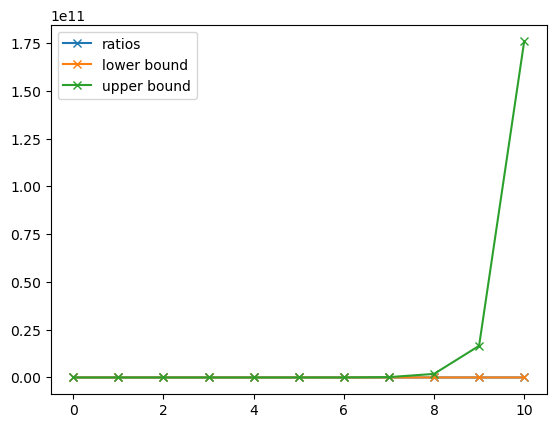

In [18]:
plt.plot(ratios,marker='x',label="ratios")
plt.plot(lows,marker='x',label="lower bound")
plt.plot(ups,marker='x',label="upper bound")
plt.legend()
#plt.yscale('log')

## Finite Difference Noise

We can find the coefficients use to calculate the finite differences for different orders in https://en.wikipedia.org/wiki/Finite_difference_coefficient. Calculator https://web.media.mit.edu/~crtaylor/calculator.html<br>
Assuming we have equispaced data for x,and we can bound the measurement error by $\epsilon > 0$ i.e. $||u-\tilde{u}||_{\infty}< \epsilon$ and the third derivative of u
is bounded by $M(t, x) > 0$ on each interval $[x − h, x + h]$. Then, we get tha
$$|u_x(t, x) − \tilde{u}_x(t, x)| ≤ \frac{\epsilon}{h} + \frac{h^2}{6}M(t,x)$$
is the 2nd order centered finite differences approximation of the derivative of $\tilde{u}$.

TODO: error bound for different orders, centered and left-off-centered/backward differences (even/odd order)?<br>
Question: do the same error bounds count at the boundary values of u?? For centered Differences no-> can lead to wron errorbound especially since exp has high values at boundary point

For even order: centered differenced, for uneven order backward differences:<br>
order = 1: <br>
Approximation: $\frac{u(x)-u(x-h)}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h}{2}||u'||_{\infty}+\frac{2\epsilon}{h}$ 
<br>
order = 2: <br>
Approximation: $\frac{u(x+\frac{h}{2})-u(x-\frac{h}{2})}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^2}{3}||u^3||_{\infty}+\frac{2\epsilon}{h}$ <br>
(Here we use h/2 since for h the calculation did not work out -> makes more sense???)
order = 4: <br>
Approximation: see book or wiki,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^4}{30}||u^5||_{\infty}+\frac{9 \epsilon}{6h}$ <br>

In [8]:
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)


a=np.random.randn()
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
dx=x[1]-x[0]

In [4]:
ux_fd = ps.FiniteDifference(order=3,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux_fd.flatten()
g= np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print(g.shape)
print(f"Matrix rank = {matrix_rank(g)}, svd = {svd(g, compute_uv=False)}")

(40000, 2)
Matrix rank = 2, svd = [1.44484004e+06 5.75819370e-01]


### Check difference between noisy derivative and correct derivative

To approximate $\|u'-\tilde{u}'\|$

General formula for central differences: $$ \text{sum over ceofficients} \frac{\epsilon}{h} + h^{order} \|u^{order+1}\|_{\infty}\frac{(order/2)!^2}{(order+1)!}$$

For backward differences: $$ \text{sum over ceofficients}\frac{\epsilon}{h} + h^{order}\|u^{order+1}\|_{\infty} \frac{1}{order+1}$$

Here compute functions for computing lagrange coefficients and sum(for calculating measurment error) 
$$L_{n,k}(x) =\prod_{i=0,i\neq k}^n \frac{x-x_i}{x_k-x_i}$$
$$  L'_{n,k}(x) = [\prod_{i=0,i\neq k}^n \frac{1}{x_k-x_i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (x-x_i)
$$
$$  L'_{n,k}(x_l)= h^{-1}[\prod_{i=0,i\neq k}^n \frac{1}{k-i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (l-i) = h^{-1} \sum_{j=0,j\neq k}^n \frac{1}{k-j} \prod_{i=0,i\neq k,j}^n \frac{l-i}{k-i}$$
Note here n stands for the order as well. (wiki link to polynomial and derivatives: https://en.wikipedia.org/wiki/Lagrange_polynomial)
The functions for calculating this is in error_bounds.py

#### Plots for analysining the "knick" in finite differences error

The Measurment error increases while the approximation error decreases. If in the beginning the measurment error is strictly smaller than the approximation error this can lead to the knick". If not than no "knick" should be visible.

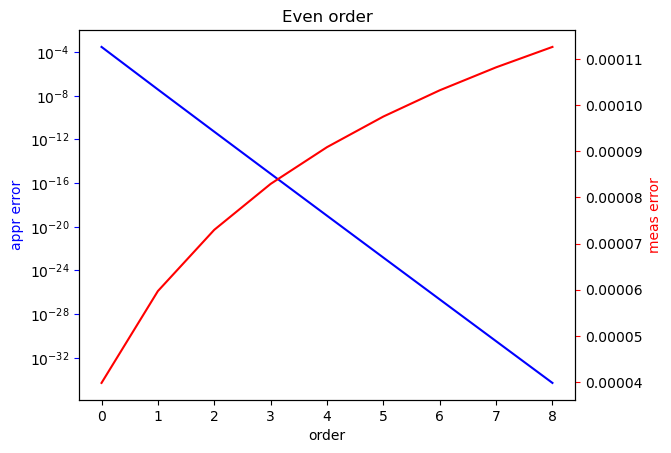

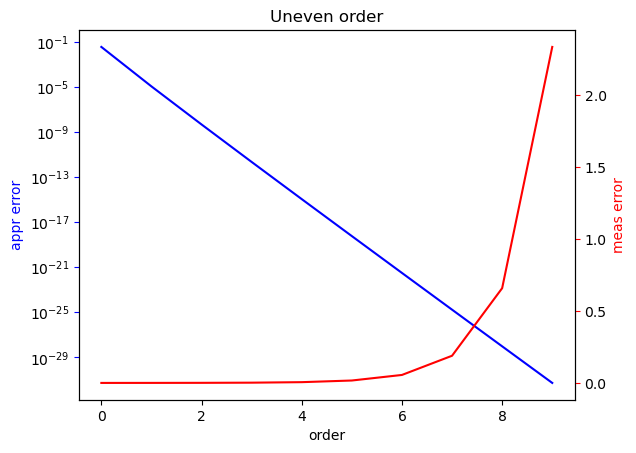

In [5]:
meas_error_list_even=[]
app_error_list_even=[]
meas_error_list_uneven=[]
app_error_list_uneven=[]
h=dx
eps=1e-6#np.finfo(float).eps # if this is big enough no knick will be visible, note it mus be very small for the knick to be visple
M=2.78
for order in range(1,20,1):
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)*h**order*M
        C_meas=meas_error_central_diff(order)*eps/h
        app_error_list_even.append(C_app)
        meas_error_list_even.append(C_meas)
    else: # odd order
        C_app=appr_error_backward_diff(order)*h**order*M
        C_meas=meas_error_backward_diff(order)*eps/h
        app_error_list_uneven.append(C_app)
        meas_error_list_uneven.append(C_meas)

fig, ax1 = plt.subplots()
plt.title("Even order")
ax1.set_xlabel('order')
color = 'blue'
ax1.set_ylabel('appr error', color=color)
ax1.plot(app_error_list_even,color=color)
ax1.tick_params(axis='y', color=color)
plt.yscale('log')

ax2 = ax1.twinx()  
color='red'
ax2.set_ylabel('meas error', color=color)  
ax2.plot(meas_error_list_even, color=color)
ax2.tick_params(axis='y', color=color)

fig, ax1 = plt.subplots()
plt.title("Uneven order")
ax1.set_xlabel('order')
color = 'blue'
ax1.set_ylabel('appr error', color=color)
ax1.plot(app_error_list_uneven,color=color)
ax1.tick_params(axis='y', color=color)
plt.yscale('log')

ax2 = ax1.twinx()  
color='red'
ax2.set_ylabel('meas error', color=color)  
ax2.plot(meas_error_list_uneven, color=color)
ax2.tick_params(axis='y', color=color)

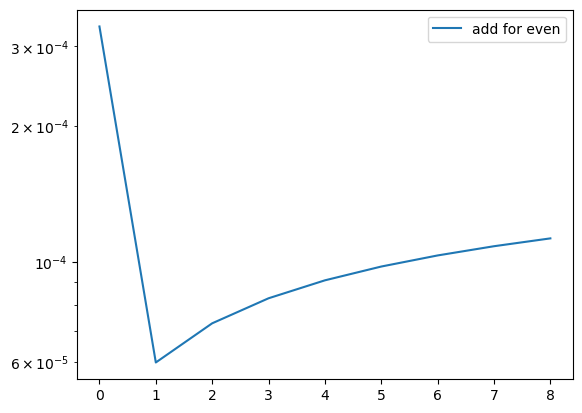

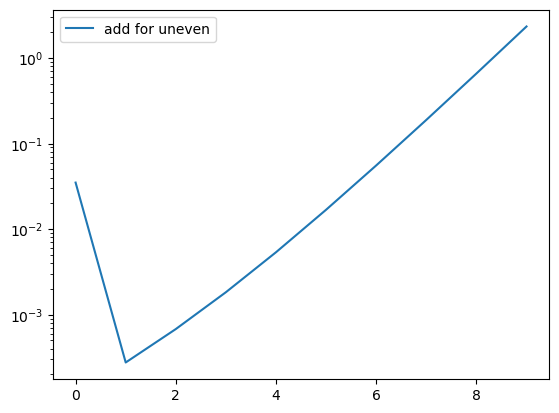

In [6]:
combined_list = [x + y for x, y in zip(meas_error_list_even, app_error_list_even)]
plt.plot(combined_list,label='add for even')
plt.legend()
plt.yscale('log')
plt.show()
combined_list = [x + y for x, y in zip(meas_error_list_uneven, app_error_list_uneven)]
plt.plot(combined_list,label='add for uneven')
plt.yscale('log')
plt.legend()

#### Analysis of Noise on derivative

In [7]:
target_noise=1e-9
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
order=2
ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)

In [8]:
infinity_norm(ux-ux_noise)

11.208771337951475

In [9]:
eps=infinity_norm(u_noise-u)
M=infinity_norm(uxxx)
h=dx
print(f"eps: {eps}, M: {M}, h: {h}")

eps: 2.4201184714911506e-05, M: 54279.04382537057, h: 0.02512562814070352


##### With Boundary values
Error bound smaller than difference for oder =^1? -> wrong formula
three poiint midpoint ?/ numerical mistakes in error bound calcuation?<br>
What about the boundary values for central diff??? -> I think they are the reason the bound fails for some noise levels since we can not use central differnce at the boundary values!

Noise level 	  eps 	 	 $max|ux-ux_noise|$ 	 bound
0 	 	  0.0000 	 11.2093 	 	 5.7110
1e-10 	 	  0.0000 	 11.2093 	 	 5.7111
1e-09 	 	  0.0000 	 11.2100 	 	 5.7119
1e-08 	 	  0.0002 	 11.2103 	 	 5.7199
1e-07 	 	  0.0024 	 11.1971 	 	 5.8056
1e-06 	 	  0.0213 	 11.0053 	 	 6.5575
1e-05 	 	  0.2076 	 18.1593 	 	 13.9753
0.0001 	 	  2.0354 	 146.5885 	 	 86.7216
0.001 	 	  21.1109 	 1464.6369 	 	 845.9257
0.01 	 	  203.8434 	 19790.8735 	 	 8118.6800
0.1 	 	  2220.9981 	 170551.2471 	 	 88401.4347


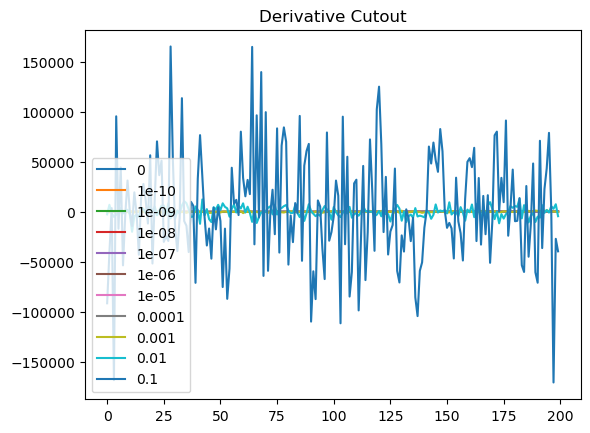

In [10]:
M=infinity_norm(uxxx)
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t  eps \t \t $max|ux-ux_noise|$ \t bound")
plt.title("Derivative Cutout")
order=2
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(u)))
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    plt.plot(ux_noise[0,:],label=str(target_noise))
    eps = infinity_norm(u_noise-u)
    bound = error_bound_finite_diff(eps,dx,M,order)
    diff = infinity_norm(ux-ux_noise)
    print(f"{target_noise} \t \t  {eps:.4f} \t {diff:.4f} \t \t {bound:.4f}")
plt.legend()
plt.show()

In [11]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        eps = infinity_norm(u_noise-u)
        bound = error_bound_finite_diff(eps,dx,M,order)
        diff = infinity_norm(ux-ux_noise)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 676.2222 	 681.8975
	 1e-10	 	  0.000 	 676.2222 	 681.8977
	 1e-09	 	  0.000 	 676.2227 	 681.8994
	 1e-08	 	  0.000 	 676.2208 	 681.9151
	 1e-07	 	  0.002 	 676.1759 	 682.0693
	 1e-06	 	  0.024 	 676.2329 	 683.7824
	 1e-05	 	  0.220 	 674.9246 	 699.3793
	 0.0001	 	  2.209 	 702.9399 	 857.7496
	 0.001	 	  21.275 	 1503.4898 	 2375.4180
	 0.01	 	  233.192 	 12925.2543 	 19243.9947
2
	 0	 	  0.000 	 11.2093 	 5.7110
	 1e-10	 	  0.000 	 11.2093 	 5.7111
	 1e-09	 	  0.000 	 11.2096 	 5.7119
	 1e-08	 	  0.000 	 11.2018 	 5.7194
	 1e-07	 	  0.002 	 11.2334 	 5.7992
	 1e-06	 	  0.023 	 11.3437 	 6.6133
	 1e-05	 	  0.219 	 22.9527 	 14.4255
	 0.0001	 	  2.251 	 169.7219 	 95.3110
	 0.001	 	  22.763 	 1562.1008 	 911.6884
	 0.01	 	  228.615 	 15453.5609 	 9104.6048
3
	 0	 	  0.000 	 0.2089 	 0.2152
	 1e-10	 	  0.000 	 0.2088 	 0.2158
	 1e-09	 	  0.000 	 0.2093 	 0.2210
	 1e-08	 	  0.000 	 0.2061 	 0.2742
	 1e-07	 	  0.0

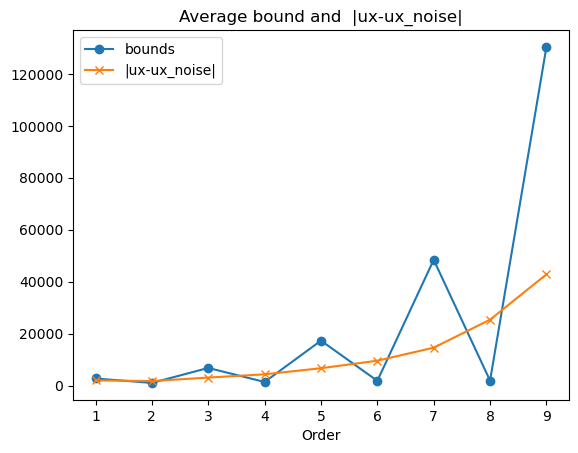

In [12]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

##### Without boundary values

In [13]:
M=infinity_norm(uxxx)
number_noise=8 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(ux_noise).all(axis=1)
        col_mask = ~np.isnan(ux_noise).all(axis=0)
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound_finite_diff(eps,dx,M,order)
        diff = infinity_norm(ux[row_mask][:, col_mask]-ux_noise[row_mask][:, col_mask])
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 670.5824 	 681.8975
	 1e-10	 	  0.000 	 670.5824 	 681.8977
	 1e-09	 	  0.000 	 670.5821 	 681.8992
	 1e-08	 	  0.000 	 670.5778 	 681.9146
	 1e-07	 	  0.002 	 670.5054 	 682.0731
	 1e-06	 	  0.022 	 670.2828 	 683.6700
	 1e-05	 	  0.215 	 666.4130 	 699.0316
	 0.0001	 	  2.205 	 677.6918 	 857.4182
2
	 0	 	  0.000 	 5.5695 	 5.7110
	 1e-10	 	  0.000 	 5.5695 	 5.7111
	 1e-09	 	  0.000 	 5.5696 	 5.7119
	 1e-08	 	  0.000 	 5.5701 	 5.7195
	 1e-07	 	  0.002 	 5.5790 	 5.8004
	 1e-06	 	  0.022 	 5.5616 	 6.5705
	 1e-05	 	  0.236 	 7.8848 	 15.0925
	 0.0001	 	  2.050 	 59.7744 	 87.3010
3
	 0	 	  0.000 	 0.0689 	 0.2152
	 1e-10	 	  0.000 	 0.0689 	 0.2158
	 1e-09	 	  0.000 	 0.0687 	 0.2209
	 1e-08	 	  0.000 	 0.0766 	 0.2715
	 1e-07	 	  0.002 	 0.1256 	 0.8702
	 1e-06	 	  0.020 	 0.9959 	 5.6319
	 1e-05	 	  0.230 	 10.1954 	 61.1817
	 0.0001	 	  2.081 	 98.0815 	 552.4815
4
	 0	 	  0.000 	 0.0007 	 0.0007
	 1e-10	 	  0

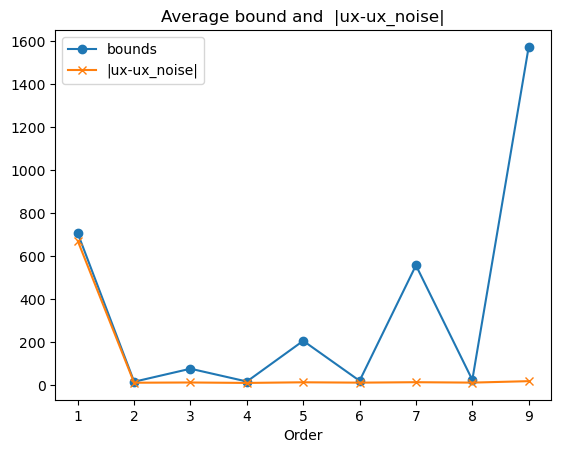

In [14]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

Plot accuracy and bound depending on error

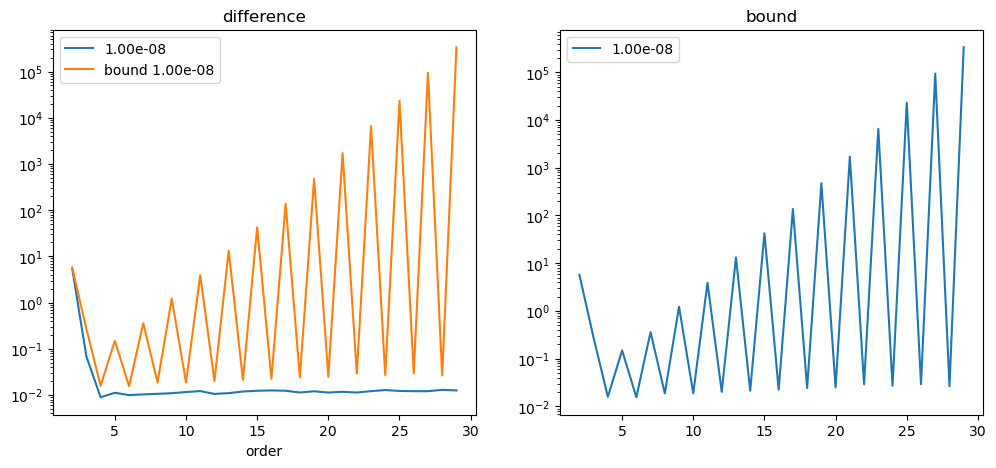

In [15]:
M=infinity_norm(uxxx)
number_noise=8 #<=10
noise_levels = [1e-8]#+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,30,1)
#print("Noise level \t Order \t  eps \t \t|ux-ux_noise| \t bound")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('order')
for target_noise in noise_levels:
    #print(f"{target_noise}")
    diff_list = []
    bound_list = []
    avg_diff=0
    avg_bound=0
    for order in orders:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(ux_noise).all(axis=1)
        col_mask = ~np.isnan(ux_noise).all(axis=0)
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound_finite_diff(eps,dx,M,order)
        diff = infinity_norm(ux[row_mask][:, col_mask]-ux_noise[row_mask][:, col_mask])
        avg_bound+=bound
        avg_diff+=diff
        diff_list.append(diff)
        bound_list.append(bound)
        #print(f"\t \t {order}\t \t  {eps:.5f} \t {diff:.5f} \t {bound:.5f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    plt.subplot(1,2,1)
    plt.title("difference")
    plt.plot(orders,diff_list,label = f"{target_noise:2.2e}")
    plt.plot(orders,bound_list,label = f"bound {target_noise:2.2e}")
    plt.legend()
    plt.yscale('log')
    plt.subplot(1,2,2)
    plt.yscale('log')
    plt.title("bound")
    plt.plot(orders,bound_list,label = f"{target_noise:2.2e}")
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)
plt.legend()    

### Nth derivative error

We should be able to calculate the error calculation of nth derivative on $u$ by finite differences recursively???

In [61]:
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)

"""
a=np.random.randn()
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)

dx=x[1]-x[0]

In [62]:
"""
This should bound the error of finite differences on the nth derivative by a recursive schema
eps_infty:bounds the infinty norm norm max|u-u_noise|<=eps_infty
n: order of the derivative
order: order of the finite difference calculation
M: M must be the supremum over all ith derivative for i = n+order+1,n+order,...,order+1
"""
def error_bound_finite_diff_nth_derivative(eps_infty,n,order,M,h, C_app=None,C_meas=None):
    if n == 0:
        return eps_infty+np.finfo(float).eps
    #Only calculalate measurement and approximatin error once in the beginning 
    if C_app==None or C_meas==None:
        if order%2==0: #even order
            C_app=appr_error_central_diff(order)
            C_meas=meas_error_central_diff(order)
        else: # odd order
            C_app=appr_error_backward_diff(order)
            C_meas=meas_error_backward_diff(order)
        
    return error_bound_finite_diff_nth_derivative(eps_infty,n-1,order,M,h,C_app,C_meas)*(C_meas/h) + (h**order)*M*C_app


In [63]:
M=infinity_norm(uxxx)
number_derivative=2
number_noise=8 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(number_derivative,10,1)
print("Order \t Noise level \t  eps \t \t|uxx-uxx_noise| \t bound")
diff_list = []
bound_list = []

for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        
        uxx_noise = ps.FiniteDifference(order=order,d=number_derivative, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(uxx_noise).all(axis=1)
        col_mask = ~np.isnan(uxx_noise).all(axis=0)
        
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound_finite_diff_nth_derivative(eps,number_derivative,order,M,dx)
        
        diff = infinity_norm(uxx[row_mask][:, col_mask]-uxx_noise[row_mask][:, col_mask])
        
        avg_bound+=bound
        avg_diff+=diff
        
        print(f"\t {target_noise}\t \t  {eps:.3e} \t {diff:.4e} \t {bound:.4e}")
        
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|uxx-uxx_noise| 	 bound
2
	 0	 	  0.000e+00 	 5.7864e-04 	 4.2928e-03
	 1e-10	 	  3.092e-10 	 5.7973e-04 	 4.2933e-03
	 1e-09	 	  2.994e-09 	 5.9141e-04 	 4.2976e-03
	 1e-08	 	  3.111e-08 	 7.8649e-04 	 4.3421e-03
	 1e-07	 	  3.004e-07 	 3.6741e-03 	 4.7686e-03
	 1e-06	 	  3.317e-06 	 2.8845e-02 	 9.5472e-03
	 1e-05	 	  3.322e-05 	 2.0868e-01 	 5.6918e-02
	 0.0001	 	  3.392e-04 	 2.1134e+00 	 5.4153e-01
3
	 0	 	  0.000e+00 	 5.2607e-05 	 1.0561e-03
	 1e-10	 	  2.957e-10 	 5.3444e-05 	 1.0769e-03
	 1e-09	 	  2.997e-09 	 6.2554e-05 	 1.2671e-03
	 1e-08	 	  2.842e-08 	 5.1802e-04 	 3.0572e-03
	 1e-07	 	  3.236e-07 	 4.8050e-03 	 2.3835e-02
	 1e-06	 	  3.077e-06 	 4.7641e-02 	 2.1767e-01
	 1e-05	 	  3.113e-05 	 4.8668e-01 	 2.1928e+00
	 0.0001	 	  2.942e-04 	 4.7156e+00 	 2.0717e+01
4
	 0	 	  0.000e+00 	 3.0329e-07 	 8.0637e-07
	 1e-10	 	  2.942e-10 	 8.3817e-06 	 1.8550e-06
	 1e-09	 	  2.885e-09 	 9.2882e-05 	 1.1087e-05
	 1e-08	 	  2.933e-08 	 9.1395e-04 	 1

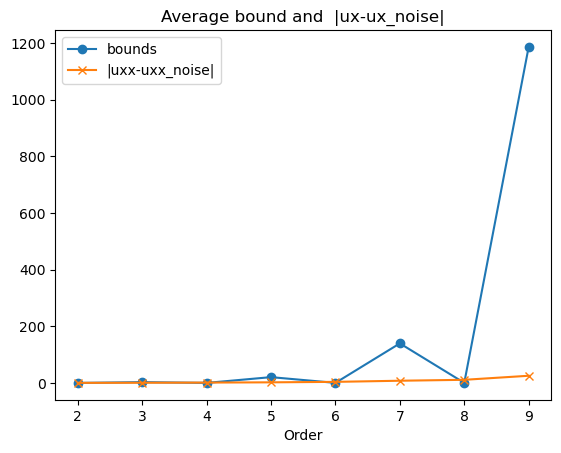

In [64]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|uxx-uxx_noise|')
plt.legend()

## Put everything together: Finite Differences and SVD

Let $\|g-\tilde{g}\|_F^2 = \sum_{i=1}^{n}\|u_{\alpha_i}-\tilde{u}_{\alpha_i}\|^2 < \|u-\tilde{u}\|^2+ \sum_{i=2}^n m\text{ errorbound}({\alpha_i},\epsilon)^2 =E $
$$| \frac{\tilde{\sigma}_1}{\tilde{\sigma}_n} - \frac{\sigma_1}{\sigma_n} | < \sqrt{(\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2) E}$$

In [16]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()#*1e-6
"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]
print(f"{dx:2.3e}")

1.010e-02


In [17]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 2.718281828459045
Singular values of g: (205.59100528590918, 1.680559098890283e-14)
sv_max/sv_min: 1.223e+16


##### Check $\sum_{i=1}^{n}\|u_{\alpha_i}-\tilde{u}_{\alpha_i}\|^2 < \sum_{i=1}^n m \text{ errorbound}({\alpha_i},\epsilon)^2  $

In [18]:
order=1
target_noise=1e-10
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
eps_two = np.linalg.norm(u-u_noise)
eps_infty = infinity_norm(u-u_noise)
M=infinity_norm(uxxx)

ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
print(f"|g-g_noise|: {np.linalg.norm(true_g-g_noise):3.2e}")
print(f"Bound: {np.sqrt(E):3.3e}")

|g-g_noise|: 7.37e-01
Bound: 1.373e+00


Check $| \frac{\tilde{\sigma}_1}{\tilde{\sigma}_n} - \frac{\sigma_1}{\sigma_n} | < (\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2) \sqrt{E}$

In [19]:
sv = svd(g_noise, compute_uv=False)
ratio = sv[0]/sv[-1]
print(f"|cond-cond_noise|: {np.abs(ratio-sv_max/sv_min):3.3e}")
print(f"Bound: {error_bound_condition(E,sv_max,sv_min):3.3e}")

|cond-cond_noise|: 1.223e+16
Bound: 9.994e+29


##### Do it for different orders and noise levels

In [21]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t |g-g_noise| \t sqrt(E) \t|c-c_noise| \t Bound")
unorm2=np.sqrt(np.mean(np.square(u)))
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * unorm2
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        eps_two = np.linalg.norm(u-u_noise)
        eps_infty = infinity_norm(u-u_noise)
        
        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        bound = error_bound_condition(E,sv_max,sv_min)
        diff = np.abs(ratio-sv_max/sv_min)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t  \t {np.linalg.norm(true_g-g_noise):3.2e} \t {np.sqrt(E):3.2e} \t{diff:3.8e} \t{bound:3.2e}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound
1
	 0	  	 7.37e-01 	 1.37e+00 	1.22334886e+16 	9.99e+29
	 1e-10	  	 7.37e-01 	 1.37e+00 	1.22334886e+16 	9.99e+29
	 1e-09	  	 7.37e-01 	 1.37e+00 	1.22334886e+16 	9.99e+29
	 1e-08	  	 7.37e-01 	 1.37e+00 	1.22334886e+16 	1.00e+30
	 1e-07	  	 7.37e-01 	 1.38e+00 	1.22334886e+16 	1.01e+30
	 1e-06	  	 7.37e-01 	 1.50e+00 	1.22334886e+16 	1.09e+30
	 1e-05	  	 7.65e-01 	 2.48e+00 	1.22334886e+16 	1.81e+30
	 0.0001	  	 2.17e+00 	 1.29e+01 	1.22334886e+16 	9.41e+30
	 0.001	  	 2.05e+01 	 1.19e+02 	1.22334886e+16 	8.68e+31
	 0.01	  	 2.01e+02 	 1.24e+03 	1.22334886e+16 	8.99e+32
2
	 0	  	 2.57e-03 	 4.62e-03 	1.22334886e+16 	3.36e+27
	 1e-10	  	 2.57e-03 	 4.63e-03 	1.22334886e+16 	3.37e+27
	 1e-09	  	 2.57e-03 	 4.68e-03 	1.22334886e+16 	3.41e+27
	 1e-08	  	 2.57e-03 	 5.17e-03 	1.22334886e+16 	3.77e+27
	 1e-07	  	 2.78e-03 	 1.01e-02 	1.22334886e+16 	7.33e+27
	 1e-06	  	 1.15e-02 	 6.63e-02 	1.22334886e+16 	4.83e+28
	 1e-05	  	

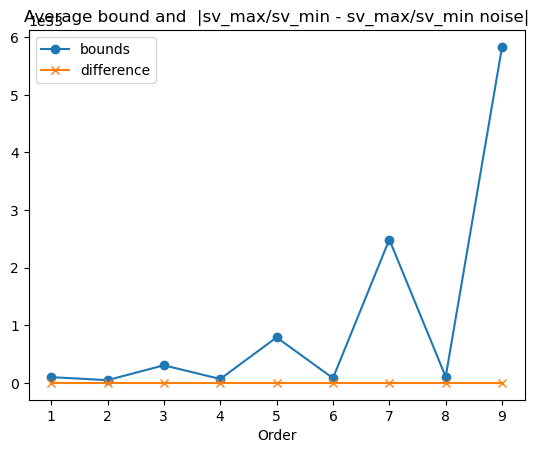

In [22]:
plt.title("Average bound and  |sv_max/sv_min - sv_max/sv_min noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='difference')
plt.legend()

##### Plot for each noise level the different orders:

For higher orders the error (at least for small enough noise i.e. noise <=1e-8) gets smaller.
It always gets better from order 1 to wo for noise <= 1e-5
If E is very small the approximaitn is not that bad.
Maybe a good lower bound would be 1e-8/1e-9/1e-10???

Note that the difference here revolves around 1e15(even for low noise levels) which is already pretty high
The difference never gets better after order=6 -> we do not need to consider this. What might be an explination for this behavior?

True ratio: 1.223e+16
Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0
0.0
	 	 1	  	 7.37e-01 	 1.37e+00 	1.22e+16 	9.99369e+29 	 1.326e+03
	 	 2	  	 2.57e-03 	 4.62e-03 	1.22e+16 	3.36488e+27 	 2.465e+05
	 	 3	  	 1.37e-05 	 7.00e-05 	1.22e+16 	5.09830e+25 	 4.858e+07
	 	 4	  	 7.00e-08 	 9.43e-08 	1.22e+16 	6.86664e+22 	 6.482e+09
	 	 5	  	 4.82e-10 	 4.80e-09 	1.22e+16 	3.49519e+21 	 6.576e+11
	 	 6	  	 4.13e-12 	 6.09e-12 	1.22e+16 	4.43493e+18 	 7.100e+13
	 	 7	  	 4.13e-12 	 1.02e-10 	1.22e+16 	7.39047e+19 	 7.096e+13
	 	 8	  	 5.67e-12 	 4.58e-12 	1.22e+16 	3.33377e+18 	 5.153e+13
	 	 9	  	 9.70e-12 	 2.97e-10 	1.22e+16 	2.15879e+20 	 3.004e+13


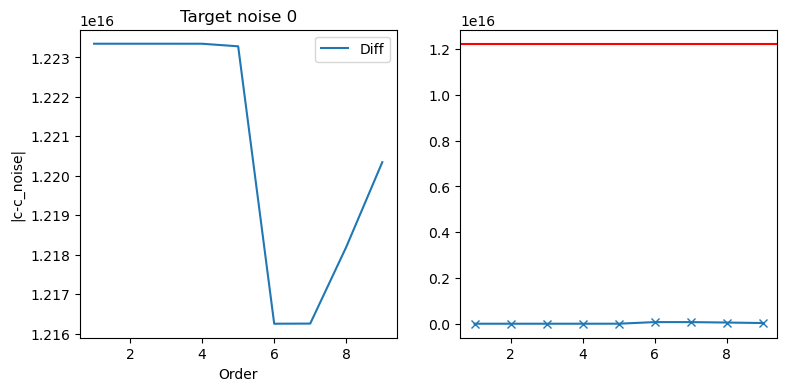

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-10
1.4450516140101143e-08
	 	 1	  	 7.37e-01 	 1.37e+00 	1.22e+16 	9.99377e+29 	 1.326e+03
	 	 2	  	 2.57e-03 	 4.63e-03 	1.22e+16 	3.36882e+27 	 2.465e+05
	 	 3	  	 1.40e-05 	 1.06e-04 	1.22e+16 	7.72779e+25 	 4.538e+07
	 	 4	  	 1.86e-06 	 8.22e-06 	1.22e+16 	5.98501e+24 	 1.561e+08
	 	 5	  	 2.52e-06 	 9.25e-05 	1.22e+16 	6.73183e+25 	 1.154e+08
	 	 6	  	 3.20e-06 	 9.93e-06 	1.22e+16 	7.23109e+24 	 9.101e+07
	 	 7	  	 4.68e-06 	 2.49e-04 	1.22e+16 	1.81510e+26 	 6.216e+07
	 	 8	  	 7.17e-06 	 1.13e-05 	1.22e+16 	8.21715e+24 	 4.055e+07
	 	 9	  	 1.17e-05 	 7.31e-04 	1.22e+16 	5.32108e+26 	 2.481e+07


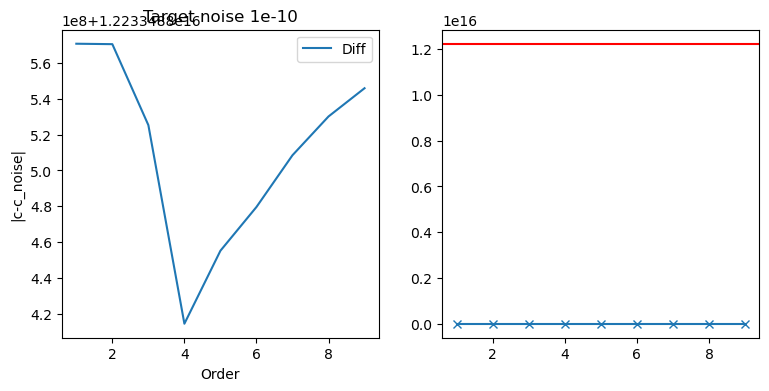

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-09
1.4515613199983717e-07
	 	 1	  	 7.37e-01 	 1.37e+00 	1.22e+16 	9.99451e+29 	 1.326e+03
	 	 2	  	 2.57e-03 	 4.68e-03 	1.22e+16 	3.40569e+27 	 2.465e+05
	 	 3	  	 2.27e-05 	 4.44e-04 	1.22e+16 	3.23051e+26 	 1.522e+07
	 	 4	  	 1.70e-05 	 8.42e-05 	1.22e+16 	6.12841e+25 	 1.709e+07
	 	 5	  	 2.31e-05 	 9.57e-04 	1.22e+16 	6.96499e+26 	 1.257e+07
	 	 6	  	 2.91e-05 	 1.03e-04 	1.22e+16 	7.48189e+25 	 9.985e+06
	 	 7	  	 4.35e-05 	 2.58e-03 	1.22e+16 	1.87805e+27 	 6.680e+06
	 	 8	  	 6.78e-05 	 1.17e-04 	1.22e+16 	8.50214e+25 	 4.288e+06
	 	 9	  	 1.13e-04 	 7.56e-03 	1.22e+16 	5.50563e+27 	 2.580e+06


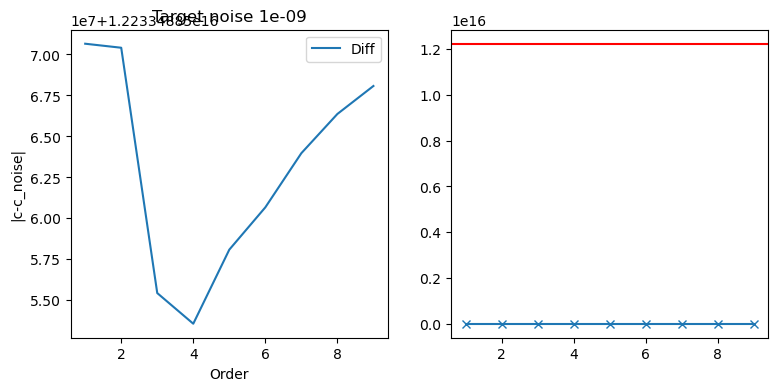

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-08
1.4537708753776268e-06
	 	 1	  	 7.37e-01 	 1.37e+00 	1.22e+16 	1.00020e+30 	 1.326e+03
	 	 2	  	 2.57e-03 	 5.19e-03 	1.22e+16 	3.78139e+27 	 2.460e+05
	 	 3	  	 1.86e-04 	 3.88e-03 	1.22e+16 	2.82774e+27 	 1.565e+06
	 	 4	  	 1.79e-04 	 8.58e-04 	1.22e+16 	6.24840e+26 	 1.627e+06
	 	 5	  	 2.39e-04 	 9.77e-03 	1.22e+16 	7.10851e+27 	 1.216e+06
	 	 6	  	 2.94e-04 	 1.05e-03 	1.22e+16 	7.63610e+26 	 9.892e+05
	 	 7	  	 4.27e-04 	 2.63e-02 	1.22e+16 	1.91676e+28 	 6.809e+05
	 	 8	  	 6.57e-04 	 1.19e-03 	1.22e+16 	8.67738e+26 	 4.423e+05
	 	 9	  	 1.09e-03 	 7.72e-02 	1.22e+16 	5.61910e+28 	 2.661e+05


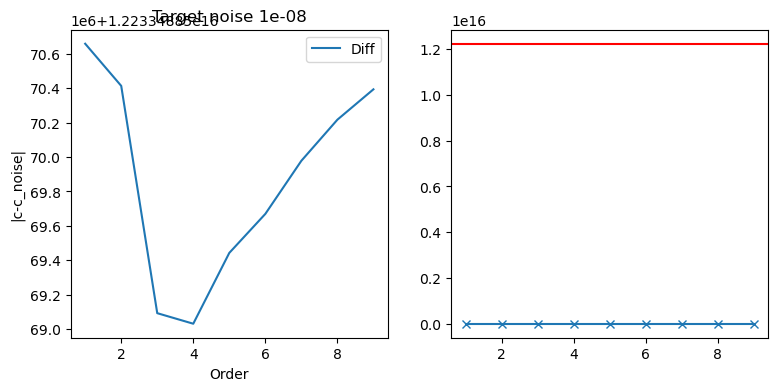

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-07
1.453670408234875e-05
	 	 1	  	 7.37e-01 	 1.38e+00 	1.22e+16 	1.00777e+30 	 1.326e+03
	 	 2	  	 2.82e-03 	 1.04e-02 	1.22e+16 	7.56337e+27 	 1.761e+05
	 	 3	  	 1.86e-03 	 3.85e-02 	1.22e+16 	2.80409e+28 	 1.562e+05
	 	 4	  	 1.80e-03 	 8.65e-03 	1.22e+16 	6.29781e+27 	 1.619e+05
	 	 5	  	 2.39e-03 	 9.84e-02 	1.22e+16 	7.16542e+28 	 1.214e+05
	 	 6	  	 2.97e-03 	 1.06e-02 	1.22e+16 	7.69723e+27 	 9.774e+04
	 	 7	  	 4.39e-03 	 2.65e-01 	1.22e+16 	1.93210e+29 	 6.618e+04
	 	 8	  	 6.85e-03 	 1.20e-02 	1.22e+16 	8.74685e+27 	 4.246e+04
	 	 9	  	 1.13e-02 	 7.78e-01 	1.22e+16 	5.66409e+29 	 2.564e+04


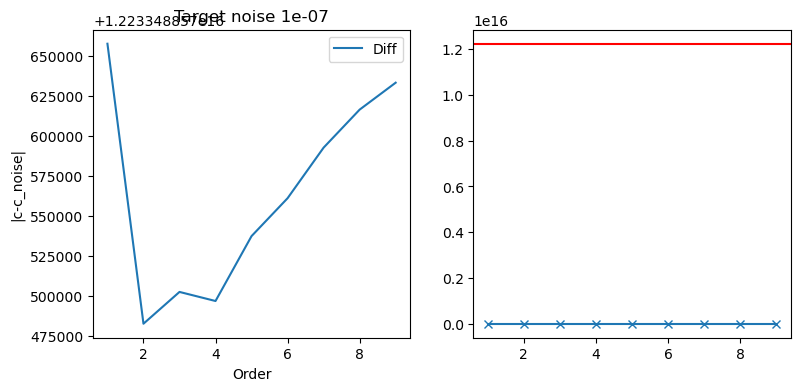

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-06
0.00014511814361411232
	 	 1	  	 7.37e-01 	 1.49e+00 	1.22e+16 	1.08191e+30 	 1.320e+03
	 	 2	  	 1.15e-02 	 6.13e-02 	1.22e+16 	4.46358e+28 	 2.586e+04
	 	 3	  	 1.84e-02 	 3.78e-01 	1.22e+16 	2.75190e+29 	 1.577e+04
	 	 4	  	 1.78e-02 	 8.50e-02 	1.22e+16 	6.19064e+28 	 1.635e+04
	 	 5	  	 2.42e-02 	 9.68e-01 	1.22e+16 	7.04355e+29 	 1.200e+04
	 	 6	  	 3.09e-02 	 1.04e-01 	1.22e+16 	7.56632e+28 	 9.421e+03
	 	 7	  	 4.62e-02 	 2.61e+00 	1.22e+16 	1.89924e+30 	 6.287e+03
	 	 8	  	 7.21e-02 	 1.18e-01 	1.22e+16 	8.59809e+28 	 4.030e+03
	 	 9	  	 1.18e-01 	 7.65e+00 	1.22e+16 	5.56776e+30 	 2.466e+03


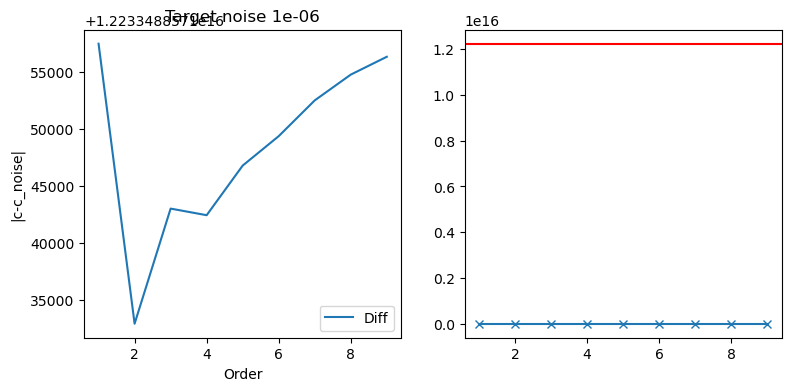

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-05
0.0014700096640876915
	 	 1	  	 7.65e-01 	 2.63e+00 	1.22e+16 	1.91757e+30 	 9.662e+02
	 	 2	  	 1.16e-01 	 6.35e-01 	1.22e+16 	4.62469e+29 	 2.503e+03
	 	 3	  	 1.89e-01 	 4.20e+00 	1.22e+16 	3.06074e+30 	 1.538e+03
	 	 4	  	 1.83e-01 	 9.46e-01 	1.22e+16 	6.88655e+29 	 1.590e+03
	 	 5	  	 2.47e-01 	 1.08e+01 	1.22e+16 	7.83535e+30 	 1.177e+03
	 	 6	  	 3.12e-01 	 1.16e+00 	1.22e+16 	8.41689e+29 	 9.311e+02
	 	 7	  	 4.65e-01 	 2.90e+01 	1.22e+16 	2.11275e+31 	 6.256e+02
	 	 8	  	 7.25e-01 	 1.31e+00 	1.22e+16 	9.56464e+29 	 4.009e+02
	 	 9	  	 1.20e+00 	 8.51e+01 	1.22e+16 	6.19366e+31 	 2.430e+02


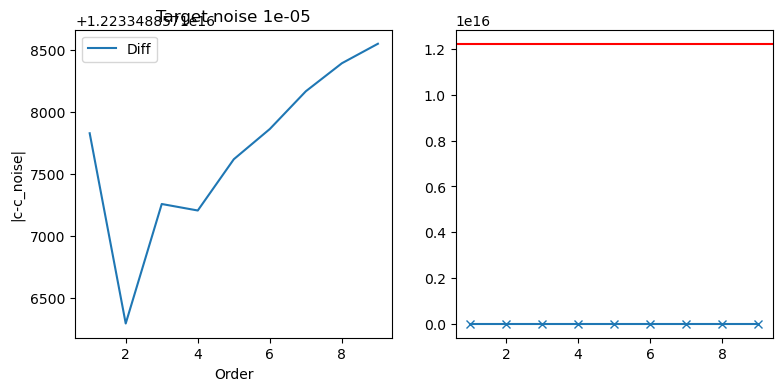

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.0001
0.01440280858471499
	 	 1	  	 2.15e+00 	 1.15e+01 	1.22e+16 	8.39564e+30 	 1.430e+02
	 	 2	  	 1.12e+00 	 5.08e+00 	1.22e+16 	3.70151e+30 	 2.590e+02
	 	 3	  	 1.84e+00 	 3.39e+01 	1.22e+16 	2.46543e+31 	 1.578e+02
	 	 4	  	 1.78e+00 	 7.62e+00 	1.22e+16 	5.54721e+30 	 1.634e+02
	 	 5	  	 2.42e+00 	 8.67e+01 	1.22e+16 	6.31148e+31 	 1.198e+02
	 	 6	  	 3.07e+00 	 9.31e+00 	1.22e+16 	6.77992e+30 	 9.466e+01
	 	 7	  	 4.52e+00 	 2.34e+02 	1.22e+16 	1.70185e+32 	 6.433e+01
	 	 8	  	 6.94e+00 	 1.06e+01 	1.22e+16 	7.70445e+30 	 4.199e+01
	 	 9	  	 1.14e+01 	 6.85e+02 	1.22e+16 	4.98908e+32 	 2.569e+01


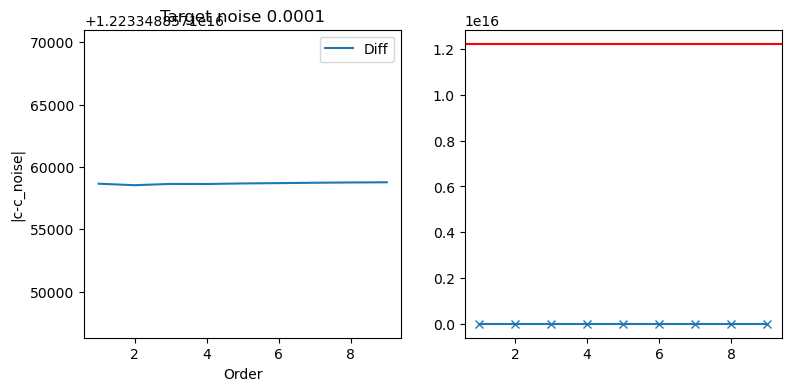

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.001
0.14551389823598138
	 	 1	  	 2.03e+01 	 1.24e+02 	1.22e+16 	9.06032e+31 	 1.437e+01
	 	 2	  	 1.12e+01 	 6.16e+01 	1.22e+16 	4.48054e+31 	 2.606e+01
	 	 3	  	 1.83e+01 	 4.10e+02 	1.22e+16 	2.98679e+32 	 1.588e+01
	 	 4	  	 1.77e+01 	 9.23e+01 	1.22e+16 	6.72029e+31 	 1.652e+01
	 	 5	  	 2.40e+01 	 1.05e+03 	1.22e+16 	7.64619e+32 	 1.218e+01
	 	 6	  	 3.05e+01 	 1.13e+02 	1.22e+16 	8.21368e+31 	 9.660e+00
	 	 7	  	 4.55e+01 	 2.83e+03 	1.22e+16 	2.06174e+33 	 6.581e+00
	 	 8	  	 7.12e+01 	 1.28e+02 	1.22e+16 	9.33373e+31 	 4.382e+00
	 	 9	  	 1.18e+02 	 8.30e+03 	1.22e+16 	6.04413e+33 	 2.969e+00


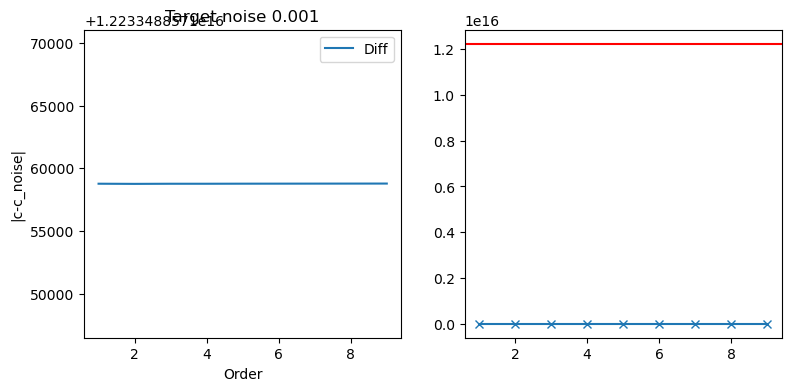

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.01
1.4634167323106793
	 	 1	  	 2.04e+02 	 1.11e+03 	1.22e+16 	8.10365e+32 	 2.404e+00
	 	 2	  	 1.14e+02 	 5.56e+02 	1.22e+16 	4.04687e+32 	 2.997e+00
	 	 3	  	 1.86e+02 	 3.71e+03 	1.22e+16 	2.69788e+33 	 2.419e+00
	 	 4	  	 1.81e+02 	 8.34e+02 	1.22e+16 	6.07025e+32 	 2.438e+00
	 	 5	  	 2.45e+02 	 9.49e+03 	1.22e+16 	6.90658e+33 	 2.457e+00
	 	 6	  	 3.11e+02 	 1.02e+03 	1.22e+16 	7.41919e+32 	 2.691e+00
	 	 7	  	 4.59e+02 	 2.56e+04 	1.22e+16 	1.86231e+34 	 3.492e+00
	 	 8	  	 7.06e+02 	 1.16e+03 	1.22e+16 	8.43089e+32 	 5.052e+00
	 	 9	  	 1.14e+03 	 7.50e+04 	1.22e+16 	5.45949e+34 	 7.951e+00


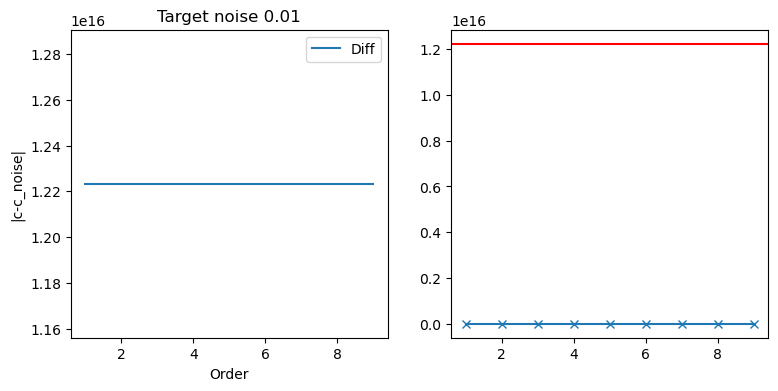

In [24]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t |g-g_noise| \t sqrt(E) \t|c-c_noise| \t Bound \t \t ratio")
    print(f"{target_noise}")
    diff_list = []
    bound_list = []
    ratio_list=[]
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)
    
    for order in orders:        
        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        bound = error_bound_condition(E,sv_max,sv_min)
        diff = np.abs(ratio-sv_max/sv_min)
        bound_list.append(bound)
        diff_list.append(diff)
        ratio_list.append(ratio)
        
        print(f"\t \t {order}\t  \t {np.linalg.norm(true_g-g_noise):3.2e} \t {np.sqrt(E):3.2e} \t{diff:3.2e} \t{bound:3.5e} \t {ratio:3.3e}")

    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.title(f"Target noise {target_noise}")
    plt.plot(orders,diff_list,label="Diff")
    #plt.plot(orders,bound_list,label="bound")
    #plt.plot(orders,ratio_list,label="ratio")
    plt.legend()
    #plt.yscale('log')
    plt.xlabel('Order')
    plt.ylabel('|c-c_noise|')
    plt.subplot(1,2,2)
    plt.plot(orders,ratio_list, marker='x',label="ratio")
    plt.axhline(y=sv_max/sv_min, color='r', label='true ratio')
    plt.show()

##### lets look at one specific example to find the reason for the "knick"

In [25]:
import pandas as pd

In [26]:
target_noise=1e-7
orders=range(1,10,1)
print(f"SV_min: {sv_min}, SV_max: {sv_max}, Ratio {sv_max/sv_min}")
df = pd.DataFrame(columns = ['order','|g-g_noise|', 'E', '|c-c_noise|','bound','ratio','sv_max','sv_min','ux-ux_noise','boundux','sv_min - |ux-ux_noise|'])
print(f"{target_noise}")
var = target_noise * unorm2
noise = np.random.normal(0, var, size=u.shape)
print(np.linalg.norm(noise))
u_noise = u + noise
eps_two = np.linalg.norm(u-u_noise)
eps_infty = infinity_norm(u_noise-u)
M=infinity_norm(uxxx)

for order in orders:  
    print(f"order {order}")
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
    sv = svd(g_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = error_bound_condition(E,sv_max,sv_min)
    diff = np.abs(ratio-sv_max/sv_min)
    boundux = np.sqrt(true_g.shape[0])*error_bound_finite_diff(eps_infty,dx,M,order)
    new_row = {'order': order, '|g-g_noise|': np.linalg.norm(true_g-g_noise), 'E': np.sqrt(E), '|c-c_noise|': diff,'bound':bound,'ratio':ratio,'sv_max':sv[0],
               'sv_min':sv[-1],'ux-ux_noise':np.linalg.norm(ux-ux_noise),'boundux':boundux,'sv_min - |ux-ux_noise|': np.abs(sv_min - np.linalg.norm(ux-ux_noise))}
    df.loc[len(df)] = new_row
    
print(df)

SV_min: 1.680559098890283e-14, SV_max: 205.59100528590918, Ratio 1.2233488570658794e+16
1e-07
1.4482221552629386e-05
order 1
order 2
order 3
order 4
order 5
order 6
order 7
order 8
order 9
   order  |g-g_noise|         E   |c-c_noise|         bound          ratio  \
0      1     0.736586  1.384699  1.223349e+16  1.007980e+30    1325.491364   
1      2     0.002821  0.010537  1.223349e+16  7.670397e+27  174317.458557   
2      3     0.001875  0.039501  1.223349e+16  2.875439e+28  154661.758781   
3      4     0.001829  0.008872  1.223349e+16  6.458344e+27  158986.462235   
4      5     0.002455  0.100943  1.223349e+16  7.348073e+28  118311.497727   
5      6     0.003053  0.010844  1.223349e+16  7.893444e+27   95249.567647   
6      7     0.004418  0.272186  1.223349e+16  1.981355e+29   65790.641212   
7      8     0.006729  0.012322  1.223349e+16  8.969821e+27   43212.872138   
8      9     0.011037  0.797932  1.223349e+16  5.808476e+29   26345.208966   

       sv_max    sv_min  ux-ux

No handles with labels found to put in legend.


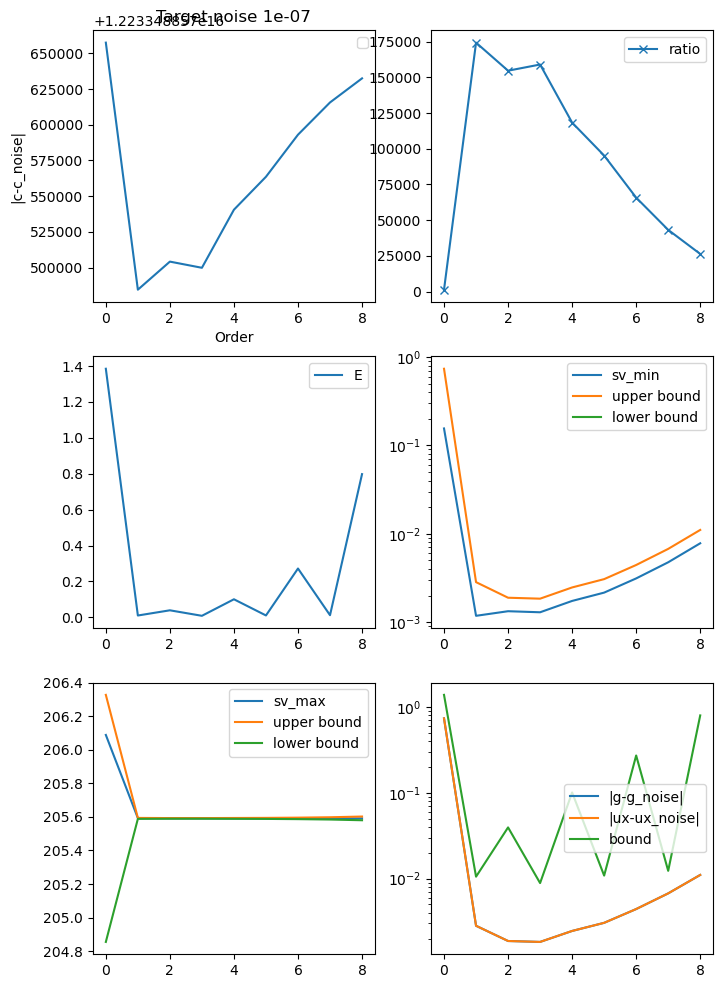

In [27]:
plt.figure(figsize=(8,12))
plt.subplot(3,2,1)
plt.title(f"Target noise {target_noise}")
plt.plot(df["|c-c_noise|"])
plt.legend()
plt.xlabel('Order')
plt.ylabel('|c-c_noise|')
plt.subplot(3,2,2)
plt.plot(df["ratio"], marker='x',label='ratio')
#plt.axhline(y=sv_max/sv_min, color='r', label='true ratio')
plt.legend()
plt.subplot(3,2,3)
plt.plot(df["E"],label='E')
plt.legend()
plt.subplot(3,2,4)
plt.plot(df["sv_min"],label='sv_min')
plt.plot(sv_min + (df["ux-ux_noise"]+eps_two),label='upper bound')
plt.plot(sv_min - (df["ux-ux_noise"]+eps_two),label='lower bound')#if it is negative nothing will be ploted
#plt.plot(df["ux-ux_noise"],label='|ux-ux_noise|')
plt.yscale('log')
plt.legend()
plt.subplot(3,2,5)
plt.plot(df["sv_max"],label='sv_max')
plt.plot(sv_max + (df["ux-ux_noise"]+eps_two),label='upper bound')
plt.plot(sv_max - (df["ux-ux_noise"]+eps_two),label='lower bound')
plt.legend()
plt.subplot(3,2,6)
plt.plot(df["|g-g_noise|"],label='|g-g_noise|')
plt.plot(df["ux-ux_noise"],label='|ux-ux_noise|')
plt.plot(df['boundux'],label='bound')# currently bound is wrong why???
plt.yscale('log')
plt.legend()
plt.show()